## PyTorch-Classification of Insects groups 


based on https://www.kaggle.com/code/basu369victor/pytorch-tutorial-the-classification/notebook

## Index
The things that are explained in this classification tutorial are given below.
* Creating a custom dataset
* Creating a neural network in PyTorch
* Training neural network in PyTorch
* Plotting of loss and accuracy curve
* evaluation of performance

## Data-set
Dataset used - [Arthropod Taxonomy Orders Object Detection Dataset](https://www.kaggle.com/mistag/arthropod-taxonomy-orders-object-detection-dataset)

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

## Device selection
Select your device, whether you to use CPU or GPU for your model.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [8]:
# BASE_PATH = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/'
BASE_PATH ="C:/Users/michalsh/Documents/Programs and programming/for git/ML projects/Classification/Insects_classisfication_neural_network/data/ArTaxOr"

os.listdir(BASE_PATH)


['Araneae',
 'ArTaxOr.png',
 'Coleoptera',
 'Diptera',
 'Hemiptera',
 'Hymenoptera',
 'Lepidoptera',
 'license.txt',
 'Odonata',
 'readme.txt',
 'revision history.txt']

In [9]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='Coleoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Coleoptera')
    if file=='Diptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Diptera')
    if file=='Hymenoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Hymenoptera')
    if file=='Lepidoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Lepidoptera')
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,002da3868a1a.jpg,Coleoptera
1,004de63c1ac1.jpg,Coleoptera
2,00930401f173.jpg,Coleoptera
3,00eebccd5430.jpg,Coleoptera
4,01424bd88646.jpg,Coleoptera


In [10]:
data.labels.unique()

array(['Coleoptera', 'Diptera', 'Hymenoptera', 'Lepidoptera'],
      dtype=object)

**NOTE** - In the cell above I have created a csv Data-frame from the raw dataset. In your case you might not have to follow this step if you are already provided with csv file which contains the desired input and target value.

In [11]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,002da3868a1a.jpg,Coleoptera,0
1,004de63c1ac1.jpg,Coleoptera,0
2,00930401f173.jpg,Coleoptera,0
3,00eebccd5430.jpg,Coleoptera,0
4,01424bd88646.jpg,Coleoptera,0


## Spliting of Dataset
I have shown two ways to split a dataset into train and validation. One is by splitting it from sratch and another method is by using train_test_split from scikit-learn( the one which I have commented out).


In [12]:
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [13]:
# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [14]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Transforms
Transforms are common image transformations. They can be chained together using **Compose**.
## Normalization
Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
Convert a PIL Image or numpy.ndarray to tensor.

## ToTensor
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

 ## Create custom dataset class
 A dataset must contain following functions to be used by data loader later on.

* __init__() function is where the initial logic happens like reading a csv, assigning transforms etc.
* __getitem__() function returns the data and labels. This function is called from dataloader like this:

> img, label = MyCustomDataset.__getitem__(99)  # For 99th item

<br>
An important thing to note is that __getitem__() return a specific type for a single data point (like a tensor, numpy array etc.), otherwise, in the data loader you will get an error like:

> TypeError: batch must contain tensors, numbers, dicts or lists; found 
> class 'PIL.PngImagePlugin.PngImageFile'

<br>
Credits: [PyTorch Custom Dataset Examples](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

In [16]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

**NOTE** - In case you already have a separate dataset set for train and validation, you could directly pass the path of the datasets to the __init__ section of the custom dataset class and read it right there and use it.

In [17]:
dataset = Arthopod_Dataset(data,BASE_PATH,transform)

In [18]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [19]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

## Visualization
visualizing the elements of the dataset

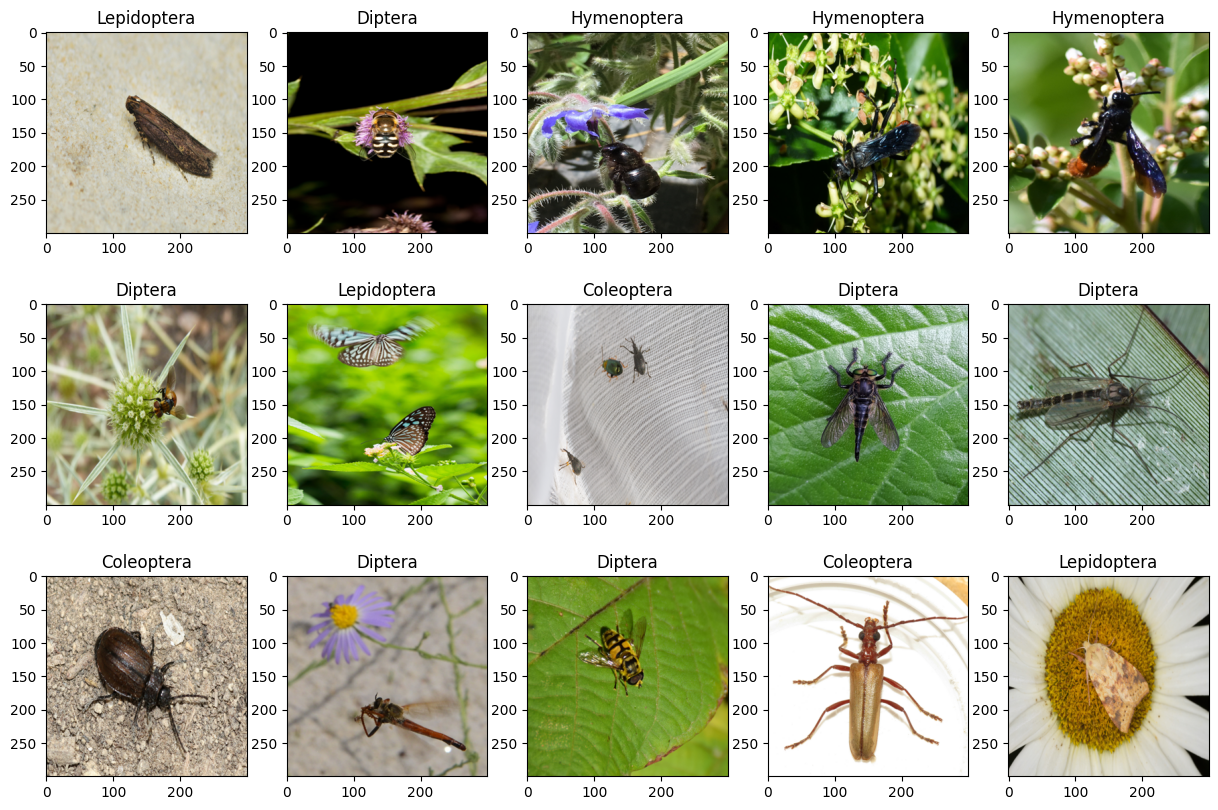

In [20]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

## The Neural Network
In the **Net** class created below, we have constructed a neural network. Construction of the neural network was the second most difficult situation that I faced after constructing a custom dataset. But I am going to explain you everything step by step.<br>
* Inside the **init()** method you declare each layer with a unique layer name. For every unique layer, declaring its input features and output features is a must. At least the input feature is a must for some of the layers like batch normalization.
* Inside the **forward(self, x)** method you need to connect the layers that were declared in the init method. One thing must be kept in mind that the output feature of one layer is an input feature of its next connecting layer.



**TIP** - If you are facing difficulty in constructing a neural network class, then I hope this tip would be very much helpful.<br><br>
Before laying your hands on PyTorch I hope you would be familiar with **Keras**( another python library for deep-learning ). And if you are not, then please go practice Keras first as it allows the simplest way of implementing a deep learning model in python.<br><br>
In Keras after implementing a neural network with Model API, there is a command called "Model.summary()" which gives you the entire structure of the neural network that you have created along with the number of parameters. Keep that summary side by side while constructing your network class in PyTorch, things would get much easier. It would be much easier to see that network summary, name the layers according to it and connect them concerning their input and output features in PyTorch. It was helpful in my case, and I hope It would be helpful to you also.
![image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQylY4AqnlZcpGxTSj7h8tG5ZeUESvLa9MLk51PDDHwkACgirUc)
<br>Link to the model whose summary I used to construct my PyTorch model - [ Classifying Cursive hiragana(崩し字) KMNIST using CNN](https://www.kaggle.com/gpreda/classifying-cursive-hiragana-kmnist-using-cnn)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout2d(0.4)  ## returned an error
        self.dropout = nn.Dropout(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [27]:
# model = Net() # On CPU
model = Net().to(device)  # On GPU


## CrossEntropyLoss
It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set. It is a prototpe of categorical crossentropy in keras.
In case of **Binary classification** use **BCELoss(Binary Cross Entropy)** or BCEWithLogitsLoss.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


## Training the Network
In the cell below, it is explained how to train your model with epochs. In the "train_loss" and "val_loss" the training loss and validation loss are stored respectively after every epoch. Similarly in case of training accuracy and validation accuracy also, the same thing happens. just remember while validation the weighhts are not upgraded thats why we use **" with torch.no_grad() "**.<br>
Here, **"Torch.max(x, dim=1)"** works same as **"np.argmax(x, axis=1)"**. We use **".item()"** to get the value inside the tensor. **torch.save(model.state_dict(), 'model_classification_tutorial.pt')** is used to save the PyTorch weight in the given directory.

In [30]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            target_t = target_t.type(torch.LongTensor)
        
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU    
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'VGGNet_insects_model_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/12], Step [0/46], Loss: 1.4168
Epoch [1/12], Step [20/46], Loss: 1.3383
Epoch [1/12], Step [40/46], Loss: 1.3038

train loss: 1.3587, train acc: 32.8970
validation loss: 1.4294, validation acc: 23.7540

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/46], Loss: 1.3276
Epoch [2/12], Step [20/46], Loss: 1.2698
Epoch [2/12], Step [40/46], Loss: 1.2824

train loss: 1.3356, train acc: 38.5119
validation loss: 1.4107, validation acc: 28.1752

Detected network improvement, saving current model
Epoch 3

Epoch [3/12], Step [0/46], Loss: 1.2582
Epoch [3/12], Step [20/46], Loss: 1.3246
Epoch [3/12], Step [40/46], Loss: 1.3085

train loss: 1.3212, train acc: 39.5797
validation loss: 1.4112, validation acc: 31.5514

Epoch 4

Epoch [4/12], Step [0/46], Loss: 1.2776
Epoch [4/12], Step [20/46], Loss: 1.2978
Epoch [4/12], Step [40/46], Loss: 1.2692

train loss: 1.3085, train acc: 41.3021
validation loss: 1.4116, validation acc: 32.1141

Epoch 5

Epoch

## Accuracy and loss Curve

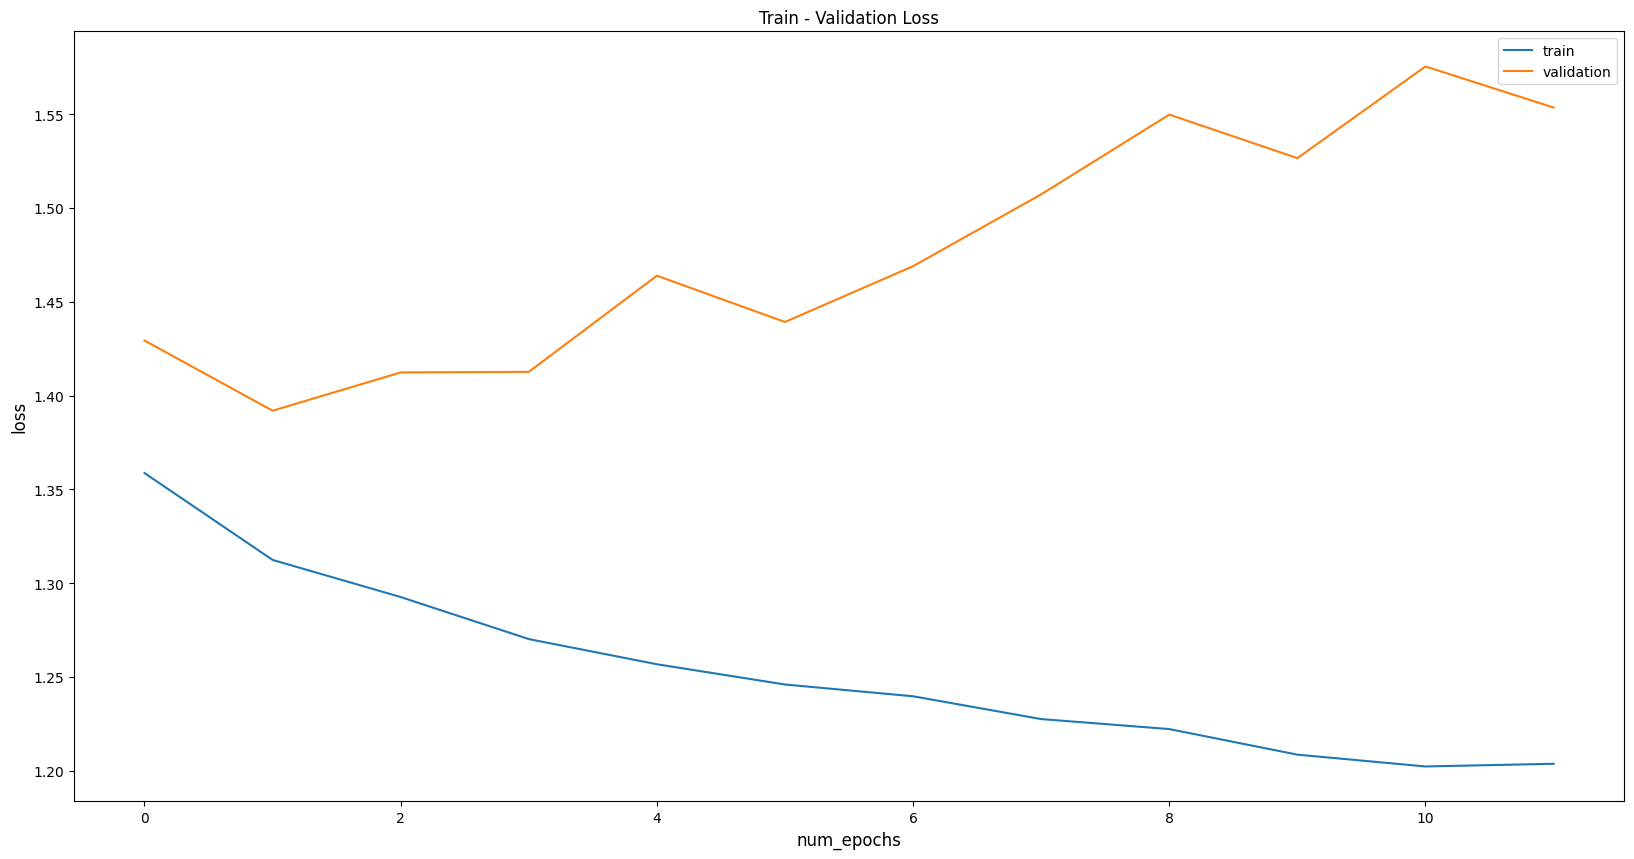

In [31]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

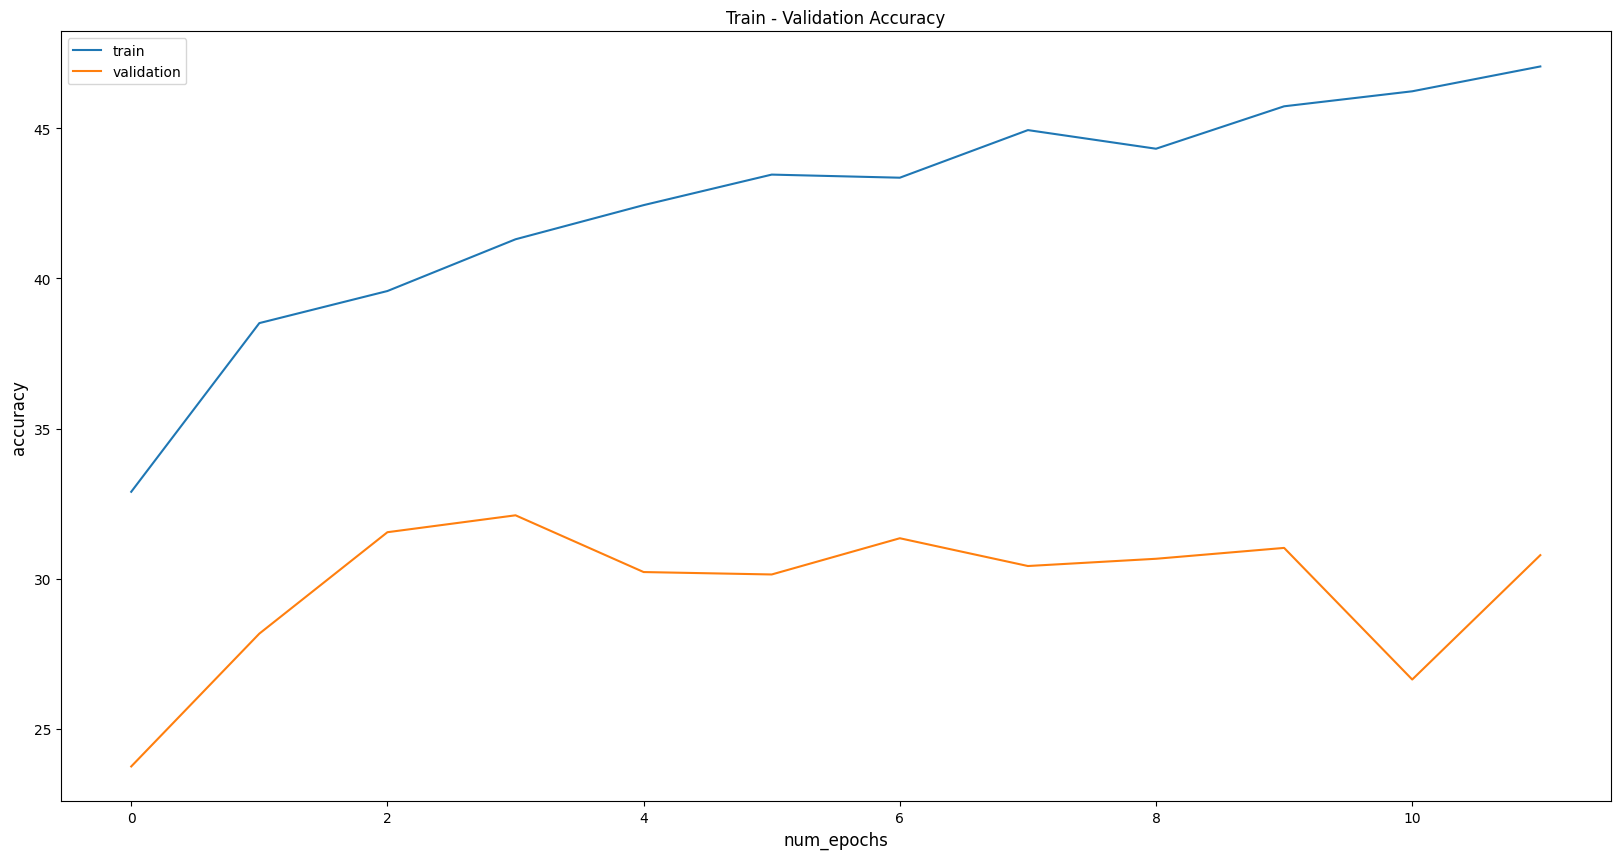

In [32]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [33]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('VGGNet_insects_model_classification.pt'))

<All keys matched successfully>

## Evaluation
evaluating the model performance through visualization

False
True
False
True
False
False
False
True
True
True
True
False
True
False
False


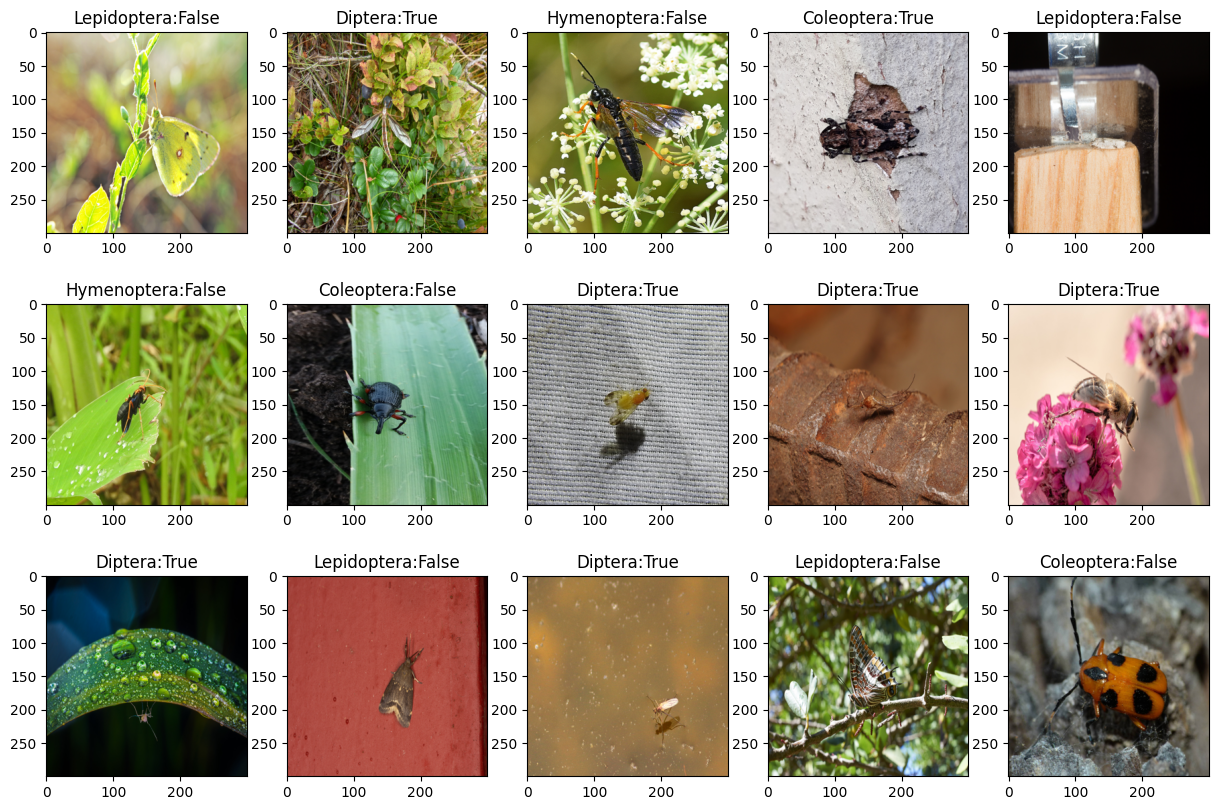

In [34]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor = image_tensor.to(device)
        
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        print(k)
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label

## Credits
* [PyTorch CNN from scratch](https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch)
* [Starting Kit for PyTorch Deep Learning](https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning)
* [Simple EDA and model in pytorch](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch)
* [CNN - Digit Recognizer (PyTorch)](https://www.kaggle.com/gustafsilva/cnn-digit-recognizer-pytorch)